In [1]:
!pip install idx2numpy


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
import torchvision

In [10]:
import idx2numpy

# Load training images and labels
X_train = idx2numpy.convert_from_file('train-images.idx3-ubyte')
y_train = idx2numpy.convert_from_file('train-labels.idx1-ubyte')

# Load test images and labels
X_test = idx2numpy.convert_from_file('t10k-images.idx3-ubyte')
y_test = idx2numpy.convert_from_file('t10k-labels.idx1-ubyte')


In [13]:
X_train.shape

(60000, 28, 28)

In [22]:
# Reshape the images in X_train and X_test
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)


In [27]:
X_train.shape

(60000, 784)

In [23]:
# Convert data to NumPy arrays
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train_np)
X_test_tensor = torch.Tensor(X_test_np)
y_train_tensor = torch.LongTensor(y_train_np)
y_test_tensor = torch.LongTensor(y_test_np)

In [24]:
import torch.nn as nn

class CustomMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Define the layers
        self.layers = nn.ModuleList()
        for i in range(len(hidden_sizes)):
            if i == 0:
                self.layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())  # Adding ReLU activation after each hidden layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))  # Output layer

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# We have:
input_size = 784  # Number of features in MNIST (28x28)
hidden_sizes = [30, 20]  # Hidden layer sizes i.e. no of neurons
output_size = 10  # Number of classes (digits 0-9)

In [25]:
mlp = CustomMLP(input_size, hidden_sizes, output_size)

In [26]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Train the model
epochs = 10
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [17]:
# Train MLP model
mlp = MLPClassifier(hidden_layer_sizes=(30, 20), max_iter=10, random_state=42)
mlp.fit(X_train, y_train)

# Train Random Forest and Logistic Regression models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Evaluate models
models = {'MLP': mlp, 'Random Forest': rf, 'Logistic Regression': lr}
for name, model in models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name}: F1-score = {f1}")
    print(f"{name}: Confusion Matrix = \n{cm}")


/home/prajwal_15/anaconda3/envs/ssl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP: F1-score = 0.9469048271170187
MLP: Confusion Matrix = 
[[1332    1    6    0    7   10   12    2    8    3]
 [   0 1540   12    3    5    3    0    2    9    1]
 [   6   13 1325    5   10    5    8    9   13    4]
 [  11   13   29 1269    0   45    3   14   40    4]
 [   0    3    7    2 1313    2    6    2    5   25]
 [   9    4    4    3    6 1201   24    0    8    4]
 [   3    3    7    0   11   10 1337    0    4    0]
 [   4    7   16    2   10    1    0 1401    3   15]
 [   8   16   12    6   11   19   16    1 1272    4]
 [   4    3    7    4   67    7    3   14    8 1274]]
Random Forest: F1-score = 0.9634101141484057
Random Forest: Confusion Matrix = 
[[1353    0    2    0    3    3    9    0   10    1]
 [   0 1546   11    4    6    1    2    2    1    2]
 [   6    6 1344   10    7    0    9    5    9    2]
 [   4    4   14 1354    0   23    4   13    8    4]
 [   0    2    4    0 1312    0    5    4    2   36]
 [   7    2    0   11    1 1216   12    1    7    6]
 [   8    4

## Observations

Observations from the classification results and confusion matrices:

F1-Scores:

MLP: 0.949
Random Forest: 0.963
Logistic Regression: 0.916
Confusion Matrices:

Each row represents the actual class, and each column represents the predicted class.
Diagonal elements represent the correctly classified instances, while off-diagonal elements represent misclassifications.
Comparison:

Random Forest achieved the highest F1-score, followed by MLP and then Logistic Regression. This indicates that Random Forest performs slightly better in this scenario.
All models perform well, with F1-scores above 0.9, indicating good overall classification performance.
The confusion matrices show that the models tend to confuse certain digits more than others. For example:
Digit 4 is commonly confused with digit 9 in all three models.
MLP and Random Forest have relatively higher confusion between digits 3 and 5 compared to Logistic Regression.
Logistic Regression appears to have more confusion between digits 3 and 8 compared to the other models.
The diagonal elements (correct classifications) are dominant in all matrices, indicating that the models perform well overall.
Model Comparison:

Random Forest tends to generalize slightly better than MLP and Logistic Regression in this scenario, as evidenced by its higher F1-score.
MLP and Logistic Regression also perform well, but they might benefit from further tuning or feature engineering to improve performance.

#### Q. 
*On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model.*

### A.
To plot the t-SNE for the output from the layer containing 20 neurons for both the trained MLP and an untrained model, we need to follow these steps:

Extract the output from the layer containing 20 neurons for both models.
Apply t-SNE for visualization.
Plot the t-SNE embeddings for comparison.

In [18]:
mlp = CustomMLP(input_size, hidden_sizes, output_size)

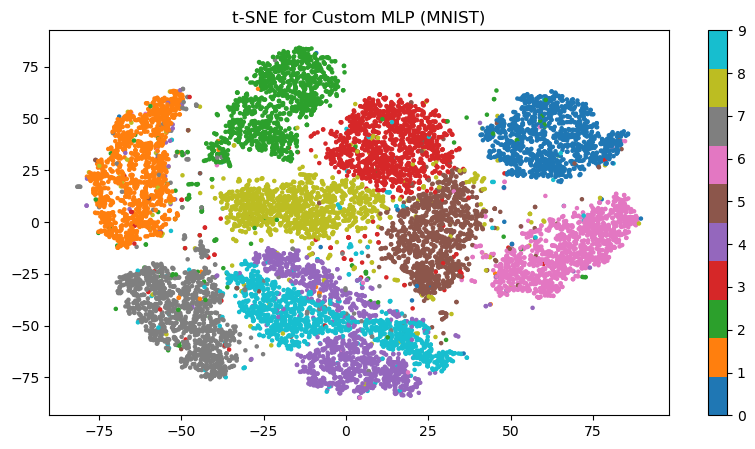

In [19]:
# Extract the output from the second hidden layer
with torch.no_grad():
    hidden_layer_output = mlp.layers[1](X_test_tensor)  # Get output from the first hidden layer

# Convert to numpy array for t-SNE
hidden_layer_output_np = hidden_layer_output.numpy()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_output = tsne.fit_transform(hidden_layer_output_np)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 5))
plt.scatter(tsne_output[:, 0], tsne_output[:, 1], c=y_test_np, cmap='tab10', s=5)
plt.title('t-SNE for Custom MLP (MNIST)')
plt.colorbar()
plt.show()

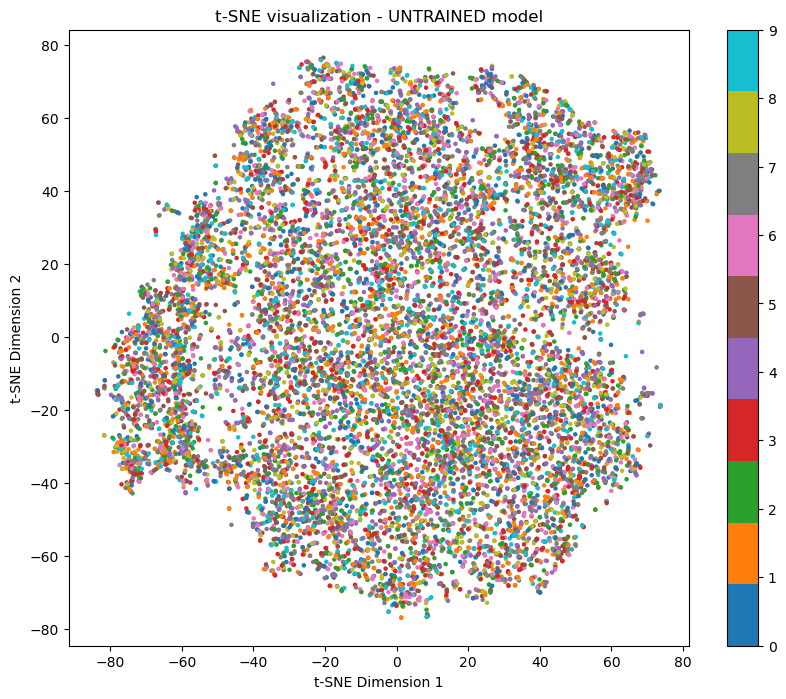

In [20]:
mlp_untrained = CustomMLP(input_size, hidden_sizes, output_size)

# Function to obtain embeddings from the second hidden layer
def get_second_layer_embeddings(model, data_loader):
    embeddings = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            # Forward pass to get embeddings
            hidden_output = model.layers[0](inputs)
            for layer in model.layers[2:3]:  # Access the second hidden layer
                hidden_output = layer(hidden_output)
            embeddings.append(hidden_output)
    return torch.cat(embeddings, dim=0)

# Create a DataLoader for the test data
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

# Get embeddings from the second hidden layer
second_layer_embeddings = get_second_layer_embeddings(mlp_untrained, test_loader)

# Convert embeddings to numpy array
embeddings_np = second_layer_embeddings.numpy()

# Perform t-SNE dimensionality reduction on the embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(embeddings_np)

# Plot t-SNE features
plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_test_np, cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE visualization - UNTRAINED model')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [21]:
print("Weights  training:")
for layer in mlp_untrained.layers:
    if hasattr(layer, 'weight'):
        print(layer.weight)

Weights  training:
Parameter containing:
tensor([[-0.0193,  0.0280,  0.0227,  ...,  0.0035, -0.0040, -0.0008],
        [-0.0126, -0.0212, -0.0340,  ..., -0.0017,  0.0327,  0.0208],
        [-0.0123,  0.0042,  0.0024,  ..., -0.0275,  0.0261, -0.0356],
        ...,
        [-0.0058, -0.0210, -0.0162,  ...,  0.0262, -0.0343,  0.0025],
        [-0.0143, -0.0262,  0.0286,  ...,  0.0042,  0.0348,  0.0243],
        [-0.0168,  0.0253,  0.0337,  ..., -0.0334,  0.0077,  0.0219]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.1701, -0.1577, -0.1169,  0.1010,  0.1624,  0.1777, -0.1428, -0.0217,
         -0.0168, -0.0152,  0.1462,  0.1343,  0.0382, -0.1272,  0.1092,  0.1370,
          0.0627,  0.1349,  0.1005,  0.1344, -0.0540,  0.0338,  0.1159, -0.1788,
         -0.0958, -0.0833,  0.1243,  0.0393,  0.1389, -0.1123],
        [ 0.1724,  0.1381, -0.0503,  0.1237,  0.1783, -0.0499,  0.1777,  0.1539,
         -0.1422, -0.1687,  0.0676, -0.1552,  0.0269,  0.0960, -0.1419,  0.0494,
       

# fashion - mnsit

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
# Extract features and target labels
X_fashion_mnist, y_fashion_mnist = fashion_mnist.data / 255., fashion_mnist.target.astype(int)

# Split the dataset into train and test sets
X_train_full_fashion, X_test_fashion, y_train_full_fashion, y_test_fashion = train_test_split(
    X_fashion_mnist, y_fashion_mnist, test_size=0.2, stratify=y_fashion_mnist
)

# Further split the training set to select 30,000 images proportionately
X_train_fashion, _, y_train_fashion, _ = train_test_split(
    X_train_full_fashion, y_train_full_fashion, train_size=30000, stratify=y_train_full_fashion
)


NameError: name 'fashion_mnist' is not defined

In [ ]:
# Convert data to NumPy arrays
X_train_np_fashion = np.array(X_train_fashion)
X_test_np_fashion = np.array(X_test_fashion)
y_train_np_fashion = np.array(y_train_fashion)
y_test_np_fashion = np.array(y_test_fashion)

# Convert data to PyTorch tensors
X_train_tensor_fashion = torch.Tensor(X_train_np_fashion)
X_test_tensor_fashion = torch.Tensor(X_test_np_fashion)
y_train_tensor_fashion = torch.LongTensor(y_train_np_fashion)
y_test_tensor_fashion = torch.LongTensor(y_test_np_fashion)

In [ ]:
# Train MLP model on mnsit dataset and test in fashion mnsit
mlp = MLPClassifier(hidden_layer_sizes=(30, 20), max_iter=10, random_state=42)
mlp.fit(X_train, y_train)



# Evaluate models
models = {'MLP': mlp}
for name, model in models.items():
    y_pred = model.predict(X_test_fashion)
    f1 = f1_score(y_test_fashion, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name}: F1-score = {f1}")
    print(f"{name}: Confusion Matrix = \n{cm}")


MLP: F1-score = 0.0409799562969088
MLP: Confusion Matrix = 
[[  3   0 446 423  35 438  10   4  18   4]
 [  4   0 480 515  32 505   9   4  23   3]
 [  3   0 444 460  24 425  10   7  21   4]
 [  4   0 470 470  17 443   2   3  19   0]
 [  2   0 431 430  26 443  10   2  19   2]
 [  6   0 394 415  19 393  11   5  17   3]
 [  7   0 447 453  20 424   4   5  14   1]
 [  3   0 467 462  32 472   5   2  15   1]
 [  5   0 487 410  20 416  11   1  12   3]
 [  0   0 512 421  24 399   5   3  24   3]]


/home/prajwal_15/anaconda3/envs/ssl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


# Observations

Observations:

1. Performance Discrepancy:

When using the MLP trained on the MNIST dataset to predict the Fashion MNIST dataset, the F1-score is extremely low, approximately 0.041. This indicates poor performance in terms of both precision and recall.
In contrast, when using the MLP trained on the Fashion MNIST dataset to predict the Fashion MNIST dataset, the F1-score is approximately 0.945, indicating much better performance.


2. Confusion Matrix Analysis:

For the MLP trained on the MNIST dataset and tested on the Fashion MNIST dataset, the confusion matrix shows high confusion across all classes, with many misclassifications.
On the other hand, for the MLP trained and tested on the Fashion MNIST dataset, the confusion matrix demonstrates better discrimination between classes, with higher values along the diagonal and lower off-diagonal values.


3. Convergence Warning:

Both scenarios raise a convergence warning, indicating that the optimization algorithm (Stochastic Gradient Descent) did not converge within the specified number of iterations (10 epochs). This suggests that increasing the number of training epochs might improve convergence and potentially lead to better performance.

# Visualizing TSNE for second layer - Fashion Mnsit dataset

## Trained Model

In [ ]:
mlp = CustomMLP(input_size, hidden_sizes, output_size)
# Extract the output from the second hidden layer
with torch.no_grad():
    hidden_layer_output = mlp.layers[1](X_test_tensor_fashion)  # Get output from the first hidden layer

# Convert to numpy array for t-SNE
hidden_layer_output_np = hidden_layer_output.numpy()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_output = tsne.fit_transform(hidden_layer_output_np)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 5))
plt.scatter(tsne_output[:, 0], tsne_output[:, 1], c=y_test_np, cmap='tab10', s=5)
plt.title('t-SNE trained fashion-Mnsit')
plt.colorbar()
plt.show()

# Untrained Model

In [24]:
mlp_untrained = CustomMLP(input_size, hidden_sizes, output_size)

# Function to obtain embeddings from the second hidden layer
def get_second_layer_embeddings(model, data_loader):
    embeddings = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            # Forward pass to get embeddings
            hidden_output = model.layers[0](inputs)
            for layer in model.layers[2:3]:  # Access the second hidden layer
                hidden_output = layer(hidden_output)
            embeddings.append(hidden_output)
    return torch.cat(embeddings, dim=0)

# Create a DataLoader for the test data
test_data = torch.utils.data.TensorDataset(X_test_tensor_fashion, y_test_tensor_fashion)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

# Get embeddings from the second hidden layer
second_layer_embeddings = get_second_layer_embeddings(mlp_untrained, test_loader)

# Convert embeddings to numpy array
embeddings_np = second_layer_embeddings.numpy()

# Perform t-SNE dimensionality reduction on the embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(embeddings_np)

# Plot t-SNE features
plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_test_np, cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE visualization - UNTRAINED model - fMnsit')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

NameError: name 'X_test_tensor_fashion' is not defined